In [1]:
# clinics compliance X patient compliance
# volume
# arrival time
# outcomes:
# waiting time
# consultation duration
# registry book: number of consultations
# exit interview: procedures
# clinics compliance X patient compliance

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

CONTROL = "#F95700FF"#"#ffc387"
TREATED = "#00A4CCFF"#"#9ed9c3"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

%matplotlib inline
sns.set_theme(style="whitegrid", palette="pastel")
set_matplotlib_formats('svg')

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

CONTROL = "#F95700FF"
TREATED = "#00A4CCFF"
palette_anc = [CONTROL, TREATED]
order=["control","treated"]

SOURCE_WT_FORMS = "Source: intervention forms"
SOURCE_REG = "Source: Facilities' registry book (Gov. of Mozambique)"

SIZE_REG_BOOK = "n = 3389(Control) 3109 (Treated)"

ROOT = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data"

cleaned_files_path = f"{ROOT}/anc/csv_cleaned"
CLEANED_DATA_PATH = f"{ROOT}/cleaned_data"
AUX = f"{ROOT}/aux"

anc_path = f"{CLEANED_DATA_PATH}/anc_cpn_endline_v20230704.csv"
anc = pd.read_csv(anc_path)

anc_page2_providers_path = f"{CLEANED_DATA_PATH}/anc_page2_providers.csv"
page2_providers = pd.read_csv(anc_page2_providers_path)
img = "graphs"

def format_graph():
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

complier_df = pd.read_stata(f"{CLEANED_DATA_PATH}/complier.dta")
facility_characteristics = pd.read_stata(f"{AUX}/facility_characteristics.dta")

volume_baseline = pd.read_stata(f"{AUX}/facility_volume_baseline.dta")

complier_df = complier_df.merge(volume_baseline, on=["facility_cod"])

<ipython-input-66-c4b32ada744b>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
<ipython-input-66-c4b32ada744b>:34: DtypeWarning: Columns (127) have mixed types. Specify dtype option on import or set low_memory=False.
  anc = pd.read_csv(anc_path)


## VOLUME

In [67]:
anc_rct = "/Users/rafaelfrade/arquivos/desenv/lse/anc_rct/"
path = f"{anc_rct}/data/sisma"

sisma_total = pd.read_stata(f"{path}/admin_anc_total.dta")
sisma1st = pd.read_stata(f"{path}/admin_anc_1st.dta")

sisma1st = sisma1st[["facility_cod", "year", "month", "anc_1st"]]
sisma = sisma_total.merge(sisma1st, 
                          left_on=["facility_cod", "year", "month"],
                          right_on=["facility_cod", "year", "month"],
                          how="inner")

sisma["anc_followup"] = sisma["anc_total"] - sisma["anc_1st"]
sisma = sisma[~sisma["anc_total"].isnull()]

sisma['date'] = pd.to_datetime(sisma[['year', 'month']].assign(DAY=1))
sisma = sisma.query("date < '2021-12-01'")

sisma.loc[sisma["treatment"] == 0, "treatment_status"] = "control"
sisma.loc[sisma["treatment"] == 1, "treatment_status"] = "treated"

#sisma["maputo"] = 0
#sisma.loc[sisma.eval("province.str.contains('Maputo')"), "maputo"] = 1
sisma = sisma.merge(facility_characteristics[["facility_cod", "maputo", 
                                      "complier", "complier10"]], 
                    on="facility_cod")

graph = pd.melt(sisma, 
                  id_vars=["facility_cod", "date", "treatment", 
                           "maputo", "province", "complier", "complier10"],
                  value_vars=["anc_1st", "anc_followup"])

anc_1st = graph.query("variable == 'anc_1st' ")
anc_followup = graph.query("variable == 'anc_followup' ")

moving_average_1st = (anc_1st
                      .set_index("date").groupby("facility_cod")["value"]
                        .rolling(window=3).mean().reset_index()
                         .rename(columns={"value":"moving_average"}))

moving_average_followup = (anc_followup
                          .set_index("date").groupby("facility_cod")["value"]
                            .rolling(window=3).mean().reset_index()
                              .rename(columns={"value":"moving_average"}))

anc_1st = graph.merge(moving_average_1st,
            on=["facility_cod", "date"])

anc_followup = graph.merge(moving_average_followup,
            on=["facility_cod", "date"])

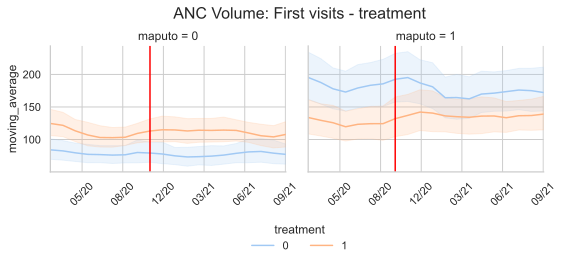

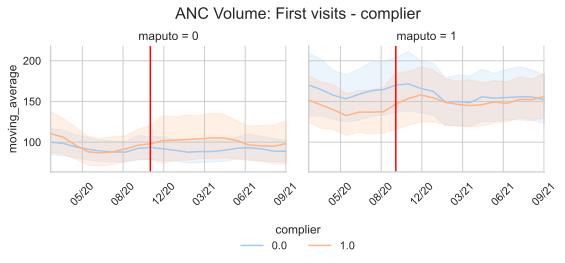

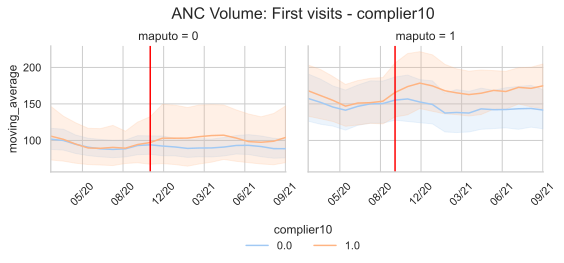

In [68]:
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
import datetime as dt

for var in ["treatment", "complier", "complier10"]:
    ax = sns.relplot(anc_1st.query("date < '2021-11-01'"), 
                 x="date", y="moving_average",#y="value",
                 hue=var, col="maputo",
                 kind="line", height=3, aspect=1.3,
                 facet_kws=dict(sharex=False))
    date_form = DateFormatter("%m/%y")

    for ax_ in ax.axes.flat:
        ax_.xaxis.set_major_locator(MaxNLocator(steps=[10]))
        ax_.xaxis.set_major_formatter(date_form)

        #ax_.legend(None)
        ax_.tick_params(axis='x', rotation=45)
        ax_.margins(x=0)
        ax_.set(xlabel="")
    ax.axes.flat[0].axvline(x=dt.datetime(2020, 11, 1), color="red")
    ax.axes.flat[1].axvline(x=dt.datetime(2020, 10, 1), color="red")

    ax.fig.suptitle(f'ANC Volume: First visits - {var}', fontsize=16)
    ax.fig.subplots_adjust(top=0.8)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.2), ncol=2)

    plt.show()

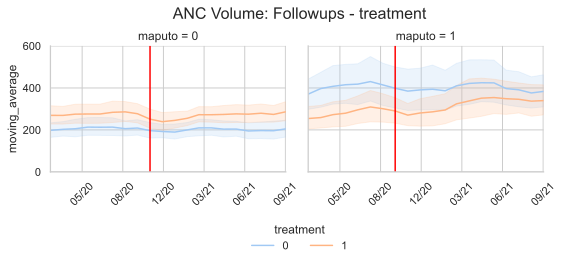

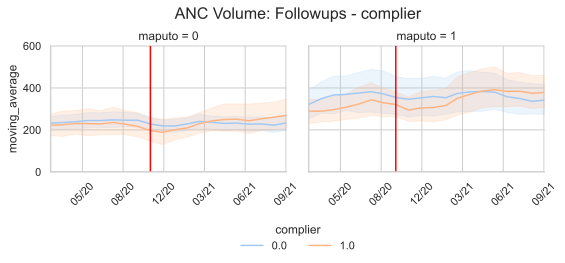

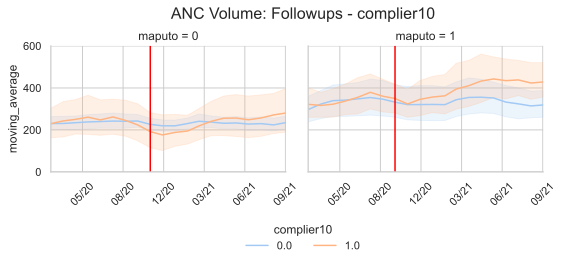

In [69]:
from matplotlib.dates import DateFormatter
for var in ["treatment", "complier", "complier10"]:
    ax = sns.relplot(anc_followup.query("date < '2021-11-01'"), 
             x="date", y="moving_average",#y="value",
             hue=var, col="maputo",
             kind="line", height=3, aspect=1.3,
             facet_kws=dict(sharex=False))
    date_form = DateFormatter("%m/%y")

    for ax_ in ax.axes.flat:
        ax_.xaxis.set_major_locator(MaxNLocator(steps=[10]))
        ax_.xaxis.set_major_formatter(date_form)

        #ax_.legend(None)
        ax_.tick_params(axis='x', rotation=45)
        ax_.margins(x=0)
        ax_.set(xlabel="")
    ax.axes.flat[0].axvline(x=dt.datetime(2020, 11, 1), color="red")
    ax.axes.flat[1].axvline(x=dt.datetime(2020, 10, 1), color="red")

    ax.fig.suptitle(f'ANC Volume: Followups - {var}', fontsize=16)
    ax.fig.subplots_adjust(top=0.8)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.ylim([0,600])

    plt.show()

## ARRIVAL TIME

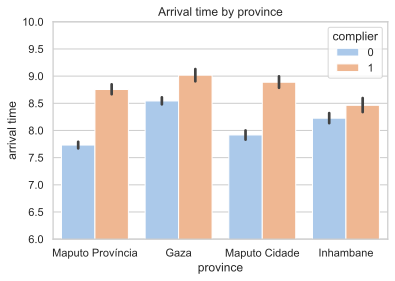

In [245]:
sns.barplot(anc.query("consultation_reason == 2"),
           x="province", y="time_arrived_float", hue="complier", errorbar=("ci",95))
plt.ylim([6,10])
plt.ylabel("arrival time")
plt.title("Arrival time by province")
plt.show()


In [251]:
(anc.query("maputo == 1 & urban == 1 & consultation_reason == 2")
    .groupby("complier10")["waiting_time"].mean())

complier10
0    139.518644
1     86.838159
Name: waiting_time, dtype: float64

In [252]:
(anc.query("maputo == 0 & urban == 1 & consultation_reason == 2")
    .groupby("complier10")["waiting_time"].mean())

complier10
0    88.001259
1    56.851429
Name: waiting_time, dtype: float64

In [257]:
import numpy as np
def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    if np.isnan(time):
        return time
    if time == "":
        return np.nan
    if len(str(time)) < 3:
        return np.nan

    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)

anc["time_entered_float"] = anc["time_entered"].apply(time_to_time_float)
anc["time_bef_consultation"] = anc["time_entered_float"] - anc["time_arrived_float"]


## Distance to province capital


Ihambane: -23.879878, 35.389587

Gaza: -25.065748, 33.678836

Maputo: -25.971554, 32.580827

In [46]:
pd.set_option('display.max_rows', 500)
facility_characteristics[["facility_cod", "facility_name", "province", "district",
                          "q013_b", "q014_b"]]#.query("q013_b == '' | q013_b.isna()")

,facility_cod,facility_name,province,district,q013_b,q014_b
0,1,CS 1 de Junho,Maputo Cidade,Kamavota,-25.9148,32.60992
1,2,CS Romao,Maputo Cidade,Kamavota,-25.87218,32.63003
2,3,CS Albazine,Maputo Cidade,Kamavota,-25.84223,32.64097
3,4,CS Porto,Maputo Cidade,Kampfumu,-25.97213,32.56545
4,5,Centro de Saude de Mavalane,Maputo Cidade,Kamavota,-25.92999,32.58548
5,6,Hospital de Dia do Centro de Saude Polana Cimento,Maputo Cidade,Kampfumu,-25.96296,32.59443
6,7,Centro de Saúde de Pescadores,Maputo Cidade,Kamavota,-25.906,32.65623
7,8,Centro de Saude Magoanine Tendas,Maputo Cidade,Kamubukwana,-25.84643,32.59739
8,9,Hospital de Dia do Mavalane,Maputo Cidade,Kamavota,-25.93123,32.58552
9,10,Centro de Saude de Bagamoyo,Maputo Cidade,Kamubukwana,-25.89753,32.57068


In [47]:
import openrouteservice

def get_driving_distance(lat_1, lon_1, lat_2, lon_2):
    
    opkey = "5b3ce3597851110001cf6248fb0ae865fbf74a4f8dae26493e8a9bb5"

    client = openrouteservice.Client(key=opkey)
    coords = ((lat_1, lon_1),
              (lat_2, lon_2))
    res = client.directions(coords)
    
    return res["routes"][0]["summary"]["distance"]



In [ ]:
get_driving_distance(lat_1, lon_1, 
                     lat_2, lon_2)


In [ ]:
capital_coords = {"Maputo Província":(-23.879878,35.389587),
                    "Gaza":(-25.065748,33.678836),
                    "Inhambane":(-25.971554,32.580827)}

driving_distance = []
for i, row in facility_characteristics.iterrows():
    lat_province = capital_coords[row["province"]][0]
    lon_province = capital_coords[row["province"]][1]

    lat_facility = facility_characteristics["q013_b"]
    lon_facility = facility_characteristics["q014_b"]
    
    distance = driving_distance.append(lat_province, lon_province,
                            lat_facility, lon_facility)
    driving_distance.append(distance)
    

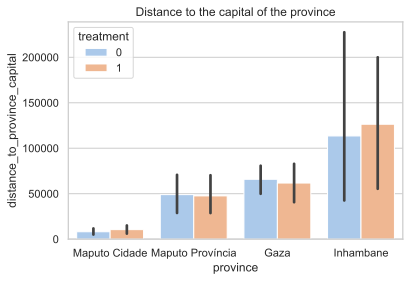

In [452]:
sns.barplot(facility_characteristics, 
            x="province", y="distance_to_province_capital",
            hue="treatment")
plt.title("Distance to the capital of the province")
plt.show()

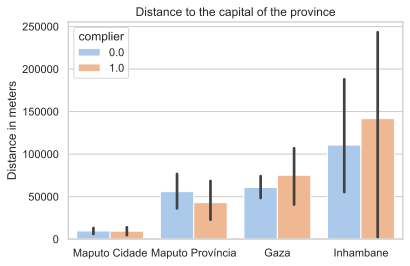

In [458]:
sns.barplot(facility_characteristics, 
            x="province", y="distance_to_province_capital",
            hue="complier")
plt.title("Distance to the capital of the province")
plt.ylabel("Distance in meters")
plt.xlabel("")
plt.show()

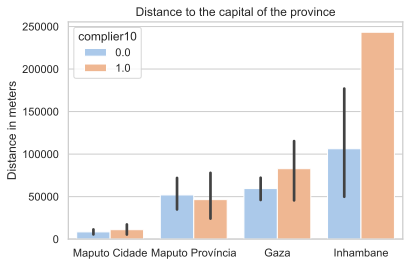

In [460]:
sns.barplot(facility_characteristics, 
            x="province", y="distance_to_province_capital",
            hue="complier10")
plt.title("Distance to the capital of the province")
plt.ylabel("Distance in meters")
plt.xlabel("")
plt.show()

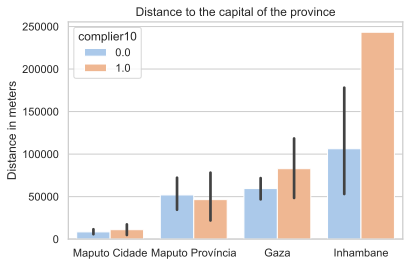

In [461]:
sns.barplot(facility_characteristics, 
            x="province", y="distance_to_province_capital",
            hue="complier10")
plt.title("Distance to the capital of the province")
plt.ylabel("Distance in meters")
plt.xlabel("")
plt.show()

## Waiting time

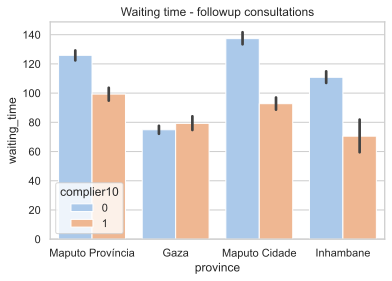

In [456]:
sns.barplot(anc.query("consultation_reason == 2"), 
            x="province", y="waiting_time",
            hue="complier10")
plt.title("Waiting time - followup consultations")
plt.show()

In [240]:
facility_characteristics.groupby(
    ["province","complier"]
).size()

province          complier
Gaza              0.0         24
                  1.0          7
Inhambane         0.0          7
                  1.0          3
Maputo Cidade     0.0          6
                  1.0          8
Maputo Província  0.0         13
                  1.0         11
dtype: int64

### Registry book

In [436]:
path = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data/cleaned_data"
reg_book = pd.read_stata(f"{path}/anc_registry_book.dta")

datena = reg_book.eval("date_1st == '' ")
reg_book.loc[:, "date_1st_na"] = 0
reg_book.loc[datena, "date_1st_na"] = 1

reg_book.loc[reg_book.eval(f"date_1st.str.contains('\/')"), "date_1st"] = "2021-06-21"

date_notna = []
for i, row in reg_book.iterrows():
    date = row["date_1st"]
    if date == "":
        for k in range(1,7):
            if row[f"date_1st_{k}"] != "":
                date = row[f"date_1st_{k}"]
    date_notna.append(date)
reg_book["date_1st"] = date_notna

In [447]:
path = "/Users/rafaelfrade/arquivos/desenv/lse/anc_hiv_scheduling/data/cleaned_data"
reg_book = pd.read_stata(f"{path}/anc_registry_book.dta")

In [448]:
from datetime import datetime as dt
dates = []

for i, row in reg_book.iterrows():
    date = row["date_1st"]

    formatted_date = None
    if "-" in date:
        formatted_date = dt.strptime(date, "%Y-%m-%d")#.date()
    else:
        formatted_date = dt.strptime(date, '%d%b%Y')#.date()

    dates.append( formatted_date )

reg_book.loc[:,"date_1st_formatted"] = pd.to_datetime(dates)

<ipython-input-448-3d1a471e4998>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reg_book.loc[:,"date_1st_formatted"] = pd.to_datetime(dates)


In [449]:
def diff_month(d1, d2):
    diff = (d1.year - d2.year) * 12 + d1.month - d2.month - 1
    months = (d1 - d2).days // 30
    #months = months if months < 0 else months + 1
    return months

def diff_maputo(df):
    return diff_month(df, intervention_maputo)

def diff_gaza_inhambane(df):
    return diff_month(df, intervention_ig)

intervention_maputo = dt(2020, 10, 26)
intervention_ig = dt(2020, 12, 7)

maputo = reg_book.eval("maputo == 1")
gaza_inhambane = reg_book.eval("maputo == 0")

reg_book.loc[maputo, "month_1st"] = reg_book.loc[maputo, "date_1st_formatted"].apply(diff_maputo)
reg_book.loc[gaza_inhambane, "month_1st"] = reg_book.loc[gaza_inhambane, "date_1st_formatted"].apply(diff_gaza_inhambane)

<ipython-input-449-b3852525a1ac>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reg_book.loc[maputo, "month_1st"] = reg_book.loc[maputo, "date_1st_formatted"].apply(diff_maputo)


In [451]:
(reg_book.replace("\"","")
        .replace(",","")
        .replace("\n","", regex=True)
        .to_csv(f"{path}/anc_registry_book.csv", sep=";", mode="w"))

Text(0, 0.5, '')

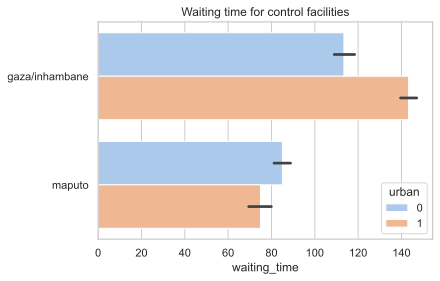

In [519]:
anc.loc[anc["maputo"] == 0, "maputo_label"] = "maputo"
anc.loc[anc["maputo"] == 1, "maputo_label"] = "gaza/inhambane"

sns.barplot(anc.query("consultation_reason == 2 & treatment == 0"),
            x="waiting_time", y="maputo_label", hue="urban",
            errorbar=("ci",95))
plt.title("Waiting time for control facilities")
plt.ylabel("")

## Patient compliance

<ipython-input-540-8e9daecd0070>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notna["time_scheduled_float"] = (notna["time_scheduled_hours"]
<ipython-input-540-8e9daecd0070>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notna["time_bef_consultation"] = notna["time_scheduled_float"] - notna["time_arrived_float"]


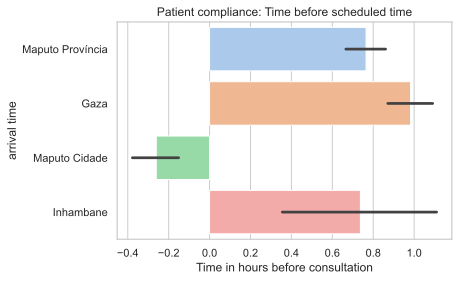

In [540]:
notna = anc.query("time_scheduled_hours.notna()")
notna["time_scheduled_float"] = (notna["time_scheduled_hours"]
                                     .replace(".0","").astype(int)
                                    .apply(time_to_time_float))


#notna["time_scheduled_float"] = notna["time_scheduled_float"].astype(int).apply(time_to_time_float)
notna["time_bef_consultation"] = notna["time_scheduled_float"] - notna["time_arrived_float"]
notna = notna.query("time_bef_consultation.between(-4,4)")
sns.barplot(notna.query("consultation_reason == 2 & complier10==1"),
            x="time_bef_consultation", y="province", 
            errorbar=("ci",95))
plt.ylabel("arrival time")
plt.title("Patient compliance: Time before scheduled time")
plt.xlabel("Time in hours before consultation")

plt.show()

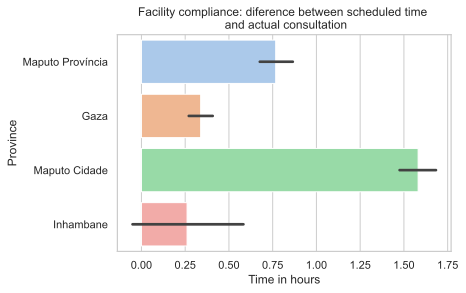

In [537]:
notna["time_bef_consultation"] = notna["time_entered_float"] - notna["time_scheduled_float"]
notna = notna.query("time_bef_consultation.between(-4,4)")
sns.barplot(notna.query("consultation_reason == 2 & complier10==1"),
            x="time_bef_consultation", y="province",
            errorbar=("ci",95))
plt.ylabel("arrival time")
plt.title("Facility compliance: diference between scheduled time \n and actual consultation")
plt.xlabel("Time in hours")
plt.ylabel("Province")
plt.show()

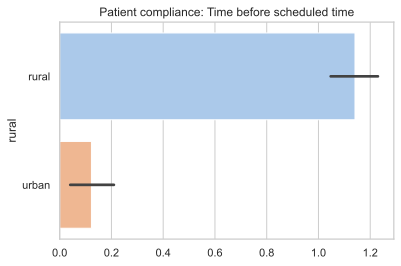

In [542]:
notna.loc[notna["urban"] == 0, "rural"] = "rural"
notna.loc[notna["urban"] == 1, "rural"] = "urban"

sns.barplot(notna.query("consultation_reason == 2 & complier10 == 1"),
            x="time_bef_consultation", y="rural",
            errorbar=("ci",95))
plt.xlabel("")
plt.title("Patient compliance: Time before scheduled time")
plt.show()

<Axes: xlabel='waiting_time', ylabel='province'>

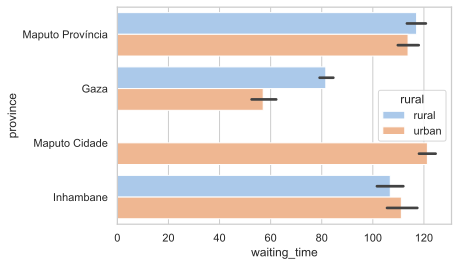

In [499]:
anc.loc[anc["urban"] == 0, "rural"] = "rural"
anc.loc[anc["urban"] == 1, "rural"] = "urban"

sns.barplot(anc.query("consultation_reason == 2"),
            x="waiting_time", y="province", hue="rural",
            errorbar=("ci",95))

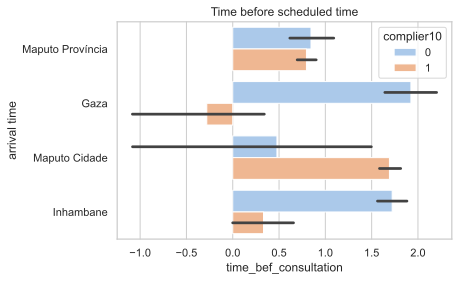

In [487]:
sns.barplot(notna.query("consultation_reason == 2"),
            x="time_bef_consultation", y="province", hue="complier10",
            errorbar=("ci",95))
plt.ylabel("arrival time")
plt.title("Time before scheduled time")
plt.show()

In [ ]:
notna["time_scheduled_float"]

In [40]:
#[c for c in anc if "sch" in c]

def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    if np.isnan(time):
        return time
    if time == "":
        return np.nan
    if len(str(time)) < 3:
        return np.nan

    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)




## Patients per hour

In [17]:
import numpy as np

def time_to_time_float(time):
    """ transforms 730 into 7.5 """
    if not time:
        return np.nan
    if np.isnan(time):
        return time
    if time == "":
        return np.nan
    if len(str(time)) < 3:
        return np.nan

    time = str(time)
    size = len(time)
    hour = float(time[0:(size-2)])
    minute = float(time[(size-2):size])
    return hour + round(minute/60, 2)

anc["time_entered_float"] = (anc["time_entered"].apply(time_to_time_float))
anc["time_left_float"] = (anc["time_left"].apply(time_to_time_float))

queue8 = (anc.query("time_arrived_float <= 8 & time_entered_float >= 8")
            .groupby(["facility_cod", "day", "day_of_week"]).size()
         .reset_index().rename(columns={0:"n_waiting_8"}))

queue10 = (anc.query("time_arrived_float <= 10 & time_entered_float >= 10")
            .groupby(["facility_cod", "day", "day_of_week"]).size()
         .reset_index().rename(columns={0:"n_waiting_10"}))

(queue8.merge(queue10, on=["facility_cod","day", "day_of_week"])
    .to_csv(f"{CLEANED_DATA_PATH}/patients_waiting.csv", index=False, mode="w"))

In [ ]:
score_basic_amenities score_basic_equipment index_general_service index_anc_readiness hospital volume_base_total

## Manual imputation

In [48]:
facility_characteristics.query("volume_base_total.isna()")

,facility_cod,index,day,treatment,complier,complier10,open,close,consultation_after_10,arrived_after_10,...,cd4_mesma_us,hemograma_mesma_us,has_lab_num,has_reception_num,maputo,distance_to_maputo,distance_to_province_capital,quality_pca,gaza_inhambane,high_quality
32,35,32,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,7.0,8473.1,-1.021005,0.0,0.0
51,54,586,1.0,1,1.0,1.0,850.0,1250.0,0.583333,0.25,...,1.0,1.0,1.0,1.0,0,141.0,114327.2,-0.166318,1.0,0.0


In [55]:
facility_characteristics.query("hospital.isna()")["facility_name"]

32    Hospital Geral da Machava
Name: facility_name, dtype: object

In [56]:
facility_characteristics = facility_characteristics.set_index("facility_cod")
facility_characteristics.loc[35, "hospital"] = 1

In [59]:
(facility_characteristics.query("province == 'Maputo Província' ")
    ["score_basic_amenities"].median())

0.6

In [60]:
(facility_characteristics.query("province == 'Maputo Província' ")
    ["score_basic_equipment"].median())

0.83333

In [61]:
(facility_characteristics.query("province == 'Maputo Província' ")
    ["index_anc_readiness"].median())

0.6

In [62]:
(facility_characteristics.query("province == 'Maputo Província' ")
    ["index_general_service"].median())

0.6775

In [63]:
(facility_characteristics.query("province == 'Maputo Província' ")
    ["index_anc_readiness"].median())

0.6

In [ ]:
facility_characteristics[]